In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import argparse
import re
import os

In [29]:
# ==================== 颜色配置常量 ====================
# 根据任务名称分配颜色（低饱和度，专业配色）
TASK_COLORS = {
    'math': (0.6, 0.2, 0.2),      # RGB: 深红色（低饱和度）
    'science': (0.3, 0.4, 0.8),   # RGB: 深蓝色（低饱和度）
    'logic': (0.3, 0.6, 0.4),     # RGB: 深绿色（低饱和度）
    'puzzle': (0.8, 0.5, 0.2),    # RGB: 橙色（低饱和度）
}

# ==================== 样式配置常量 ====================
# 曲线线条宽度
LINE_WIDTH = 4.0  # 线条粗细，可根据需要调整

# 图例字体大小
LEGEND_FONTSIZE = 12  # 图例文字大小，可根据需要调整

# 坐标轴标签字体大小
AXIS_LABEL_FONTSIZE = 20  # 横纵坐标轴标签（如"Step"、"Accuracy"）的字体大小

# 坐标轴刻度字体大小
AXIS_TICK_FONTSIZE = 15  # 坐标轴刻度数字的字体大小

# 标题字体大小
TITLE_FONTSIZE = 30  # 图表标题的字体大小

# 标记点大小
MARKER_SIZE = 9  # 数据点标记的大小

# 是否显示标题
SHOW_TITLE = False  # 设置为True显示标题，False不显示标题

# ==================== 配置参数 ====================
# 需要提取的step数据点
SELECTED_STEPS = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
# 第一阶段和第二阶段各自的步数
PHASE1_STEPS = 110
PHASE2_STEPS = 110
# 总步数
TOTAL_STEPS = PHASE1_STEPS + PHASE2_STEPS

In [4]:
def identify_columns(df):
    """
    识别第一阶段和第二阶段曲线的列名
    
    参数:
        df: pandas DataFrame，包含所有列
    
    返回:
        phase1_col: str，第一阶段曲线的列名
        phase2_cols: list，第二阶段曲线的列名列表（3个）
    """
    # 获取所有列名
    all_columns = df.columns.tolist()
    
    # 只选择mean@1列，忽略MIN和MAX列
    mean_cols = [col for col in all_columns if 'mean@1' in col and '__MIN' not in col and '__MAX' not in col]
    
    phase1_col = None
    phase2_cols = []
    
    for col in mean_cols:
        # 提取列名中的任务信息
        # 格式示例: "vanilla-Qwen3-4B-Base-math - val-core/MATH-500/acc/mean@1"
        # 或: "vanilla-Qwen3-4B-Base-math-puzzle - val-core/MATH-500/acc/mean@1"
        
        # 查找Base-后面的部分，直到遇到空格或结束
        # 使用更精确的正则表达式
        match = re.search(r'Base-([a-z]+(?:-[a-z]+)?)', col)
        if match:
            tasks_str = match.group(1)
            # 分割任务名
            task_parts = tasks_str.split('-')
            
            if len(task_parts) == 1:
                # 第一阶段：只有一个任务（如 "math"）
                phase1_col = col
            elif len(task_parts) == 2:
                # 第二阶段：有两个任务（第一阶段任务-第二阶段任务，如 "math-puzzle"）
                phase2_cols.append(col)
    
    return phase1_col, phase2_cols


def extract_data_points(df, phase1_col, phase2_cols):
    """
    从DataFrame中提取所需的数据点
    
    参数:
        df: pandas DataFrame
        phase1_col: str，第一阶段曲线列名
        phase2_cols: list，第二阶段曲线列名列表
    
    返回:
        phase1_data: dict，{'steps': [...], 'values': [...]}
        phase2_data: list of dict，每个dict包含一条第二阶段曲线的数据
    """
    # 确保Step列是整数类型
    df['Step'] = df['Step'].astype(int)
    
    # 提取第一阶段数据（step 1-110，但只取SELECTED_STEPS中的点）
    phase1_steps = [s for s in SELECTED_STEPS if s <= PHASE1_STEPS]
    phase1_data = {
        'steps': phase1_steps,
        'values': [],
        'label': phase1_col  # 保存列名用于后续颜色分配
    }
    
    for step in phase1_steps:
        row = df[df['Step'] == step]
        if not row.empty and phase1_col in row.columns:
            val = row[phase1_col].iloc[0]
            # 处理空值：检查是否为NaN、空字符串或None
            if pd.isna(val) or val == '' or val is None:
                phase1_data['values'].append(np.nan)
            else:
                try:
                    phase1_data['values'].append(float(val))
                except (ValueError, TypeError):
                    phase1_data['values'].append(np.nan)
        else:
            phase1_data['values'].append(np.nan)
    
    # 提取第二阶段数据（step 1-110，但横轴位置是111-220）
    phase2_data = []
    for col in phase2_cols:
        curve_data = {
            'steps': [],  # 实际横轴位置（111-220）
            'values': [],
            'label': col  # 保存列名用于后续标签生成
        }
        
        for step in SELECTED_STEPS:
            if step <= PHASE2_STEPS:
                # 横轴位置 = 第一阶段步数 + 当前step
                x_pos = PHASE1_STEPS + step
                row = df[df['Step'] == step]
                if not row.empty and col in row.columns:
                    val = row[col].iloc[0]
                    # 处理空值：检查是否为NaN、空字符串或None
                    if pd.isna(val) or val == '' or val is None:
                        curve_data['values'].append(np.nan)
                    else:
                        try:
                            curve_data['values'].append(float(val))
                        except (ValueError, TypeError):
                            curve_data['values'].append(np.nan)
                    curve_data['steps'].append(x_pos)
                else:
                    curve_data['values'].append(np.nan)
                    curve_data['steps'].append(x_pos)
        
        phase2_data.append(curve_data)
    
    return phase1_data, phase2_data


def generate_label(col_name):
    """
    从列名生成简短的标签
    
    参数:
        col_name: str，完整的列名
    
    返回:
        str，简短的标签
    """
    # 提取第二阶段的任务名
    # 例如: "vanilla-Qwen3-4B-Base-math-puzzle" -> "puzzle"
    match = re.search(r'Base-[^-]+-([^-]+)', col_name)
    if match:
        return match.group(1)
    return col_name


def get_phase1_task_name(col_name):
    """
    从列名中提取第一阶段的任务名称
    
    参数:
        col_name: str，完整的列名
    
    返回:
        str，第一阶段任务名称（如"math"、"logic"等）
    """
    # 提取Base-后面的第一个任务名
    # 例如: "vanilla-Qwen3-4B-Base-math" -> "math"
    # 或: "vanilla-Qwen3-4B-Base-math-puzzle" -> "math"
    match = re.search(r'Base-([a-z]+)', col_name)
    if match:
        return match.group(1)
    return ''


def get_task_color(col_name):
    """
    根据列名中的任务名称获取对应的颜色
    
    参数:
        col_name: str，完整的列名
    
    返回:
        tuple，RGB颜色值，如果找不到匹配的任务则返回黑色
    
    说明:
        - 对于第一阶段曲线（如"Base-math"），使用第一阶段任务的颜色
        - 对于第二阶段曲线（如"Base-math-puzzle"），使用第二阶段任务的颜色（puzzle）
    """
    # 提取Base-后面的所有任务名称
    # 格式示例: "vanilla-Qwen3-4B-Base-math" -> ["math"]
    # 或: "vanilla-Qwen3-4B-Base-math-puzzle" -> ["math", "puzzle"]
    match = re.search(r'Base-([a-z]+(?:-[a-z]+)?)', col_name)
    if match:
        tasks_str = match.group(1)
        task_parts = tasks_str.split('-')
        
        # 如果有两个任务（第二阶段曲线），使用第二个任务的颜色
        # 如果只有一个任务（第一阶段曲线），使用第一个任务的颜色
        if len(task_parts) == 2:
            # 第二阶段曲线，使用第二阶段任务的颜色
            task_name = task_parts[1]
        elif len(task_parts) == 1:
            # 第一阶段曲线，使用第一阶段任务的颜色
            task_name = task_parts[0]
        else:
            # 异常情况，返回黑色
            return (0.0, 0.0, 0.0)
        
        # 查找匹配的颜色
        if task_name in TASK_COLORS:
            return TASK_COLORS[task_name]
    
    # 如果找不到匹配的任务，返回黑色作为默认值
    return (0.0, 0.0, 0.0)


In [5]:
def plot_curves(phase1_data, phase2_data, output_path, title=None):
    """
    绘制分段曲线图
    
    参数:
        phase1_data: dict，第一阶段数据
        phase2_data: list of dict，第二阶段数据列表
        output_path: str，输出图片路径
        title: str，图表标题（可选）
    """
    # 设置中文字体（如果需要显示中文）
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'Liberation Sans']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建图形
    fig, ax = plt.subplots(figsize=(6, 3))
    
    # 绘制第一阶段曲线（根据任务名称分配颜色）
    phase1_steps = phase1_data['steps']
    phase1_values = phase1_data['values']
    phase1_col_name = phase1_data.get('label', '')
    
    # 获取第一阶段曲线的颜色（根据任务名称）
    phase1_color = get_task_color(phase1_col_name)
    
    # 获取第一阶段任务名称，用于图例标签
    phase1_task_name = get_phase1_task_name(phase1_col_name)
    phase1_label = f'Phase 1: {phase1_task_name}' if phase1_task_name else 'Phase 1'
    
    # 过滤掉NaN值
    valid_indices = [i for i, v in enumerate(phase1_values) if not np.isnan(v)]
    if valid_indices:
        valid_steps = [phase1_steps[i] for i in valid_indices]
        valid_values = [phase1_values[i] for i in valid_indices]
        ax.plot(valid_steps, valid_values, 
                color=phase1_color, 
                linewidth=LINE_WIDTH, 
                marker='o', 
                markersize=MARKER_SIZE,
                label=phase1_label)
    
    # 获取第一阶段最后一个有效点的值（用于连接第二阶段曲线）
    phase1_last_value = None
    if phase1_values and not np.isnan(phase1_values[-1]):
        phase1_last_value = phase1_values[-1]
    
    # 绘制第二阶段曲线（3条分叉曲线，根据任务名称分配颜色）
    for i, curve_data in enumerate(phase2_data):
        steps = curve_data['steps']
        values = curve_data['values']
        col_name = curve_data['label']
        
        # 获取第二阶段曲线的颜色（根据任务名称）
        phase2_color = get_task_color(col_name)
        
        # 如果第一阶段有最后一个值，将第二阶段曲线的起始点连接到第一阶段最后一个点
        plot_steps = steps.copy()
        plot_values = values.copy()
        
        if phase1_last_value is not None and len(steps) > 0:
            # 在第一阶段最后一个点（step 110）处添加连接点
            plot_steps = [PHASE1_STEPS] + steps
            # 使用第一阶段最后一个值作为连接点
            plot_values = [phase1_last_value] + values
        
        # 过滤掉NaN值
        valid_indices = [j for j, v in enumerate(plot_values) if not np.isnan(v)]
        if valid_indices:
            valid_steps = [plot_steps[j] for j in valid_indices]
            valid_values = [plot_values[j] for j in valid_indices]
            
            # 生成标签
            label = generate_label(col_name)
            
            ax.plot(valid_steps, valid_values,
                   color=phase2_color,
                   linewidth=LINE_WIDTH,
                   marker='o',
                   markersize=MARKER_SIZE,
                   label=f'Phase 2: {label}')
    
    # 在第一阶段和第二阶段之间添加垂直分割线
    ax.axvline(x=PHASE1_STEPS, color='gray', linestyle='--', linewidth=4, alpha=0.5)
    
    # 设置坐标轴
    ax.set_xlabel('Step', fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel('Accuracy', fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_xlim(0, TOTAL_STEPS)
    
    # 设置x轴刻度
    # 显示关键点：0, 110, 220，以及中间的一些点
    ax.set_xticks([0, 55, 110, 165, 220])
    ax.set_xticklabels(['0', '55', '110', '165', '220'])
    # 设置坐标轴刻度字体大小
    ax.tick_params(axis='both', which='major', labelsize=AXIS_TICK_FONTSIZE)
    
    # 添加网格
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # 添加图例（只有Phase 1加粗）
    legend = ax.legend(loc='best', fontsize=LEGEND_FONTSIZE)
    # 只对Phase 1的图例文字设置为粗体，Phase 2保持正常字体
    for text in legend.get_texts():
        if text.get_text().startswith('Phase 1'):
            text.set_fontweight('bold')
    
    # 设置标题（根据SHOW_TITLE常量决定是否显示）
    if SHOW_TITLE and title:
        ax.set_title(title, fontsize=TITLE_FONTSIZE, fontweight='bold')
    
    # 调整布局
    plt.tight_layout()
    
    # 保存图片
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"图表已保存至: {output_path}")
    
    # 显示图片（可选）
    plt.show()
    
    plt.close()



图表已保存至: draw/fig/science_curve.pdf


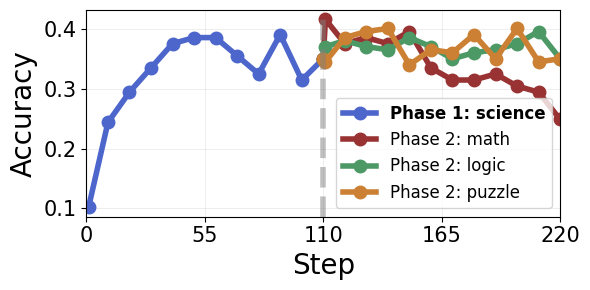

In [30]:

input_file = 'draw/data/science.csv'
output_file = 'draw/fig/science_curve.pdf'

# 读取CSV文件
df = pd.read_csv(input_file)
phase1_col, phase2_cols = identify_columns(df)
phase1_data, phase2_data = extract_data_points(df, phase1_col, phase2_cols)
plot_curves(phase1_data, phase2_data, output_file)



图表已保存至: draw/fig/math_curve.pdf


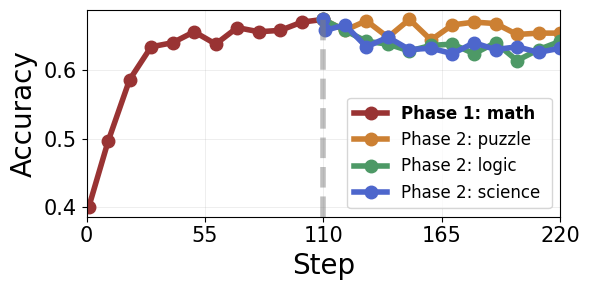

In [31]:

input_file = 'draw/data/math.csv'
output_file = 'draw/fig/math_curve.pdf'

# 读取CSV文件
df = pd.read_csv(input_file)
phase1_col, phase2_cols = identify_columns(df)
phase1_data, phase2_data = extract_data_points(df, phase1_col, phase2_cols)
plot_curves(phase1_data, phase2_data, output_file)



图表已保存至: draw/fig/puzzle_curve.pdf


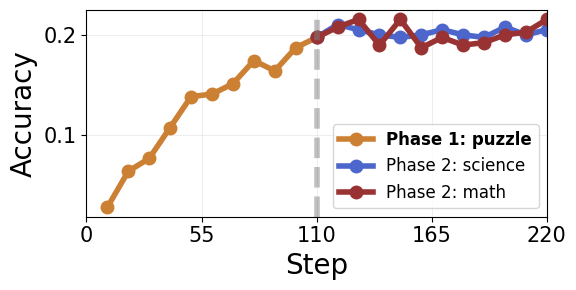

In [32]:

input_file = 'draw/data/puzzle.csv'
output_file = 'draw/fig/puzzle_curve.pdf'

# 读取CSV文件
df = pd.read_csv(input_file)
phase1_col, phase2_cols = identify_columns(df)
phase1_data, phase2_data = extract_data_points(df, phase1_col, phase2_cols)
plot_curves(phase1_data, phase2_data, output_file)



图表已保存至: draw/fig/logic_curve.pdf


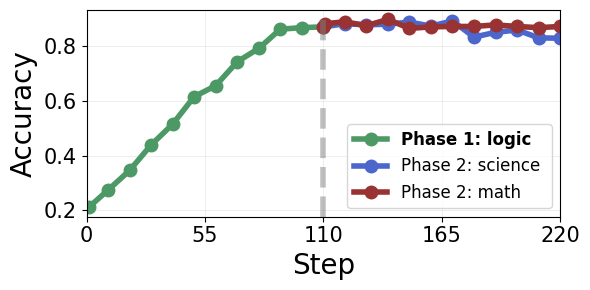

In [33]:

input_file = 'draw/data/logic.csv'
output_file = 'draw/fig/logic_curve.pdf'

# 读取CSV文件
df = pd.read_csv(input_file)
phase1_col, phase2_cols = identify_columns(df)
phase1_data, phase2_data = extract_data_points(df, phase1_col, phase2_cols)
plot_curves(phase1_data, phase2_data, output_file)

